In [1]:
# standard dependencies
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# local package dependencies
sys.path.append(os.path.abspath("../../scripts/"))
sys.path.append(os.path.abspath("../../visualizations/"))

# for making direct query requests to the data warehouse
from oso_db import execute_query

# for making visualizations
from contribution_heatmap import contribution_heatmap
from sankey import make_sankey_graph
from venn_diagram import venn3_diagram

In [3]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["axes.spines.right"] = "False"

TEAL = "#2C7FB8"
GREEN = "#2CA25F"
SEAFOAM = "#99D8C9"

# Identify relevant projects and collections

In [4]:
# create a mapping of projects to collections
result = execute_query("""
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    WHERE c."typeId" = 1 AND p."slug" != 'offchainlabs'
""", col_names=False)
projects_to_collections = {
    k: (
        sorted([
            v for v, key
            in result
            if key == k
        ]) 
    )
    for k in set(key for _, key in result)
}

In [5]:
# create a list of collections (ecosystems)
collection_slugs = list(projects_to_collections.keys())

# create a list of projects
project_slugs = set([
    p for c,ps 
    in projects_to_collections.items() 
    if c in collection_slugs 
    for p in ps
])

# identify to relevant arbitrum collections
[c for c in collection_slugs if "arb" in c]

['arbitrum-crypto-ecosystems', 'arb-onchain', 'arb-stip-1']

(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

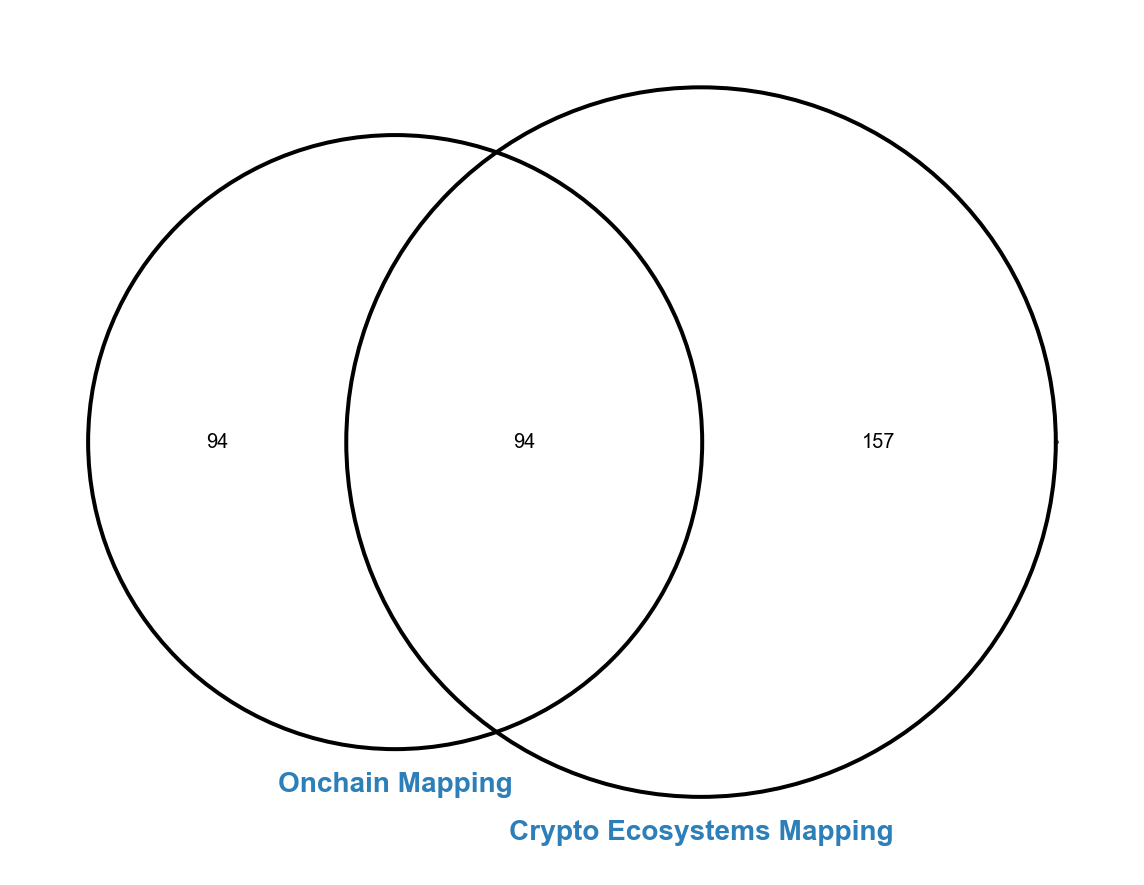

In [6]:
# visualize the intersection of the two primary collections

selected_collections = ["arb-onchain", "arbitrum-crypto-ecosystems"]
venn3_diagram(
    [set(projects_to_collections[c]) for c in selected_collections] + [set()], 
    ["Onchain Mapping", "Crypto Ecosystems Mapping", ""],
    labelcolor=TEAL,
    fontsize=12
)

In [7]:
# filter on the project slugs we're interested in
my_slugs = set(projects_to_collections['arb-onchain'] + projects_to_collections['arbitrum-crypto-ecosystems'])

# create a string version of the projects list for use in querystrings
slugs_str = "','".join(my_slugs)

len(my_slugs)

345

In [8]:
# get the names of those projects (up to 25 characters)
result = execute_query(f"""
    SELECT slug, name
    FROM project 
    WHERE slug IN ('{slugs_str}') 
""")
slugs_to_names = {x[0]: x[1][:25] for x in result}
slugs_to_names['extracredit-team'] = 'Aave (extracredit-team)'

In [9]:
ONCHAIN = 'Projects with GitHub & onchain contributions'
OTHER = 'Projects with only GitHub contributions'

def collection_tagger(s, c1='arb-onchain', c2='arbitrum-crypto-ecosystems'):
    return ONCHAIN if s in projects_to_collections[c1] else OTHER

# Look at artifacts covered

In [10]:
df_artifacts = (
    pd.read_csv("data/arb-artifact-snapshot.csv")
    .melt(
        id_vars=['project_slug'], 
        value_vars=['num_repos', 'num_contracts'], 
        var_name='Artifact', 
        value_name='count'
    )
)
df_artifacts['Artifact'].replace({'num_repos': 'GitHub repos', 'num_contracts': 'Arbitrum Contracts'}, inplace=True)
df_artifacts['Project'] = df_artifacts['project_slug'].map(slugs_to_names)
df_artifacts['Category'] = df_artifacts['project_slug'].apply(collection_tagger)
df_artifacts.dropna(inplace=True)
artifact_count = df_artifacts['count'].sum()

In [11]:
fig = make_sankey_graph(
    df=df_artifacts,
    cat_cols=['Category', 'Artifact', 'Project'],
    value_col='count',
    title=f'<b>Arbitrum coverage on OSO (January 2024)</b><br><i>A total of {artifact_count:,.0f} artifacts (GitHub repos & Arbitrum addresses) were mapped to projects</i>',
    height=1600,
    size=10,
    hide_label_cols=['Project'],
    main_color=TEAL,
    med_color=SEAFOAM,
    light_color=GREEN
)
go.Figure(fig)

# Developer activity

In [12]:
# get data about active developers (old DB)

devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "full_time_developer",
            CASE WHEN COUNT(DISTINCT e."time") < 10 THEN 1 ELSE 0 END AS "part_time_developer"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_str}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("full_time_developer") AS "full_time_developer",
        SUM("part_time_developer") AS "part_time_developer"
    FROM Devs
    GROUP BY slug, month
    ORDER BY slug, month;
""", col_names=True)

In [13]:
# get data about active developers (new DB)

"""
WITH Devs AS (
  SELECT 
      e.project_slug AS slug,
      e.from_source_id AS user,
      DATE_TRUNC(e.time, MONTH) AS month,
      CASE WHEN COUNT(DISTINCT e.time) >= 10 THEN 1 ELSE 0 END AS full_time_developer,
      CASE WHEN COUNT(DISTINCT e.time) < 10 THEN 1 ELSE 0 END AS part_time_developer
  FROM `oso-production.opensource_observer.all_events_by_project` AS e
  JOIN `oso-production.opensource_observer.collections_projects`AS cp ON e.project_slug = cp.project_slug
  WHERE
      e.type = "COMMIT_CODE"
      AND cp.collection_slug IN ('arb-onchain', 'arbitrum-crypto-ecosystems')
      -- AND e.project_slug = 'opensource-observer'
  GROUP BY
      e.project_slug,
      e.from_source_id,
      DATE_TRUNC(e.time, MONTH)
)
SELECT 
    slug,
    month,
    SUM(full_time_developer) AS full_time_developer,
    SUM(part_time_developer) AS part_time_developer
FROM Devs
GROUP BY slug, month
ORDER BY slug, month;

"""
print()

In [14]:
# load and process the data

# load database export
#df_devs = pd.read_csv("data/arb-active-devs.csv")
#df_devs['month'] = df_devs['month'].apply(lambda x: x[0:7])

# load from old DB query
df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])

# process the data
df_devs['project'] = df_devs['slug'].map(slugs_to_names)
df_devs['developers'] = df_devs['full_time_developer'] + df_devs['part_time_developer']
df_devs = df_devs[df_devs['month'] >= '2020-01']
df_devs['collection'] = df_devs['slug'].apply(collection_tagger)

df_devs

slug    month  full_time_developer  part_time_developer  \
0           0x-splits  2022-01                    1                    2   
1           0x-splits  2022-02                    2                    1   
2           0x-splits  2022-03                    2                    1   
3           0x-splits  2022-04                    1                    3   
4           0x-splits  2022-05                    0                    4   
...               ...      ...                  ...                  ...   
10260  zklinkprotocol  2023-09                    4                    5   
10261  zklinkprotocol  2023-10                    3                    6   
10262  zklinkprotocol  2023-11                    4                    6   
10263  zklinkprotocol  2023-12                    7                    8   
10264  zklinkprotocol  2024-01                    3                    9   

               project  developers  \
0             0xSplits           3   
1             0xSplits           3   
2             0xSplits           3   
3             0xSplits           4   
4             0xSplits           4   
...                ...         ...   
10260  zkLink Protocol           9   
10261  zkLink Protocol           9   
10262  zkLink Protocol          10   
10263  zkLink Protocol          15   
10264  zkLink Protocol          12   

                                         collection  
0      Projects with GitHub & onchain contributions  
1      Projects with GitHub & onchain contributions  
2      Projects with GitHub & onchain contributions  
3      Projects with GitHub & onchain contributions  
4      Projects with GitHub & onchain contributions  
...                                             ...  
10260       Projects with only GitHub contributions  
10261       Projects with only GitHub contributions  
10262       Projects with only GitHub contributions  
10263       Projects with only GitHub contributions  
10264       Projects with only GitHub contributions  

[8720 rows x 7 columns]

Text(0.0, 1.0, 'Active developer growth on Arbitrum')

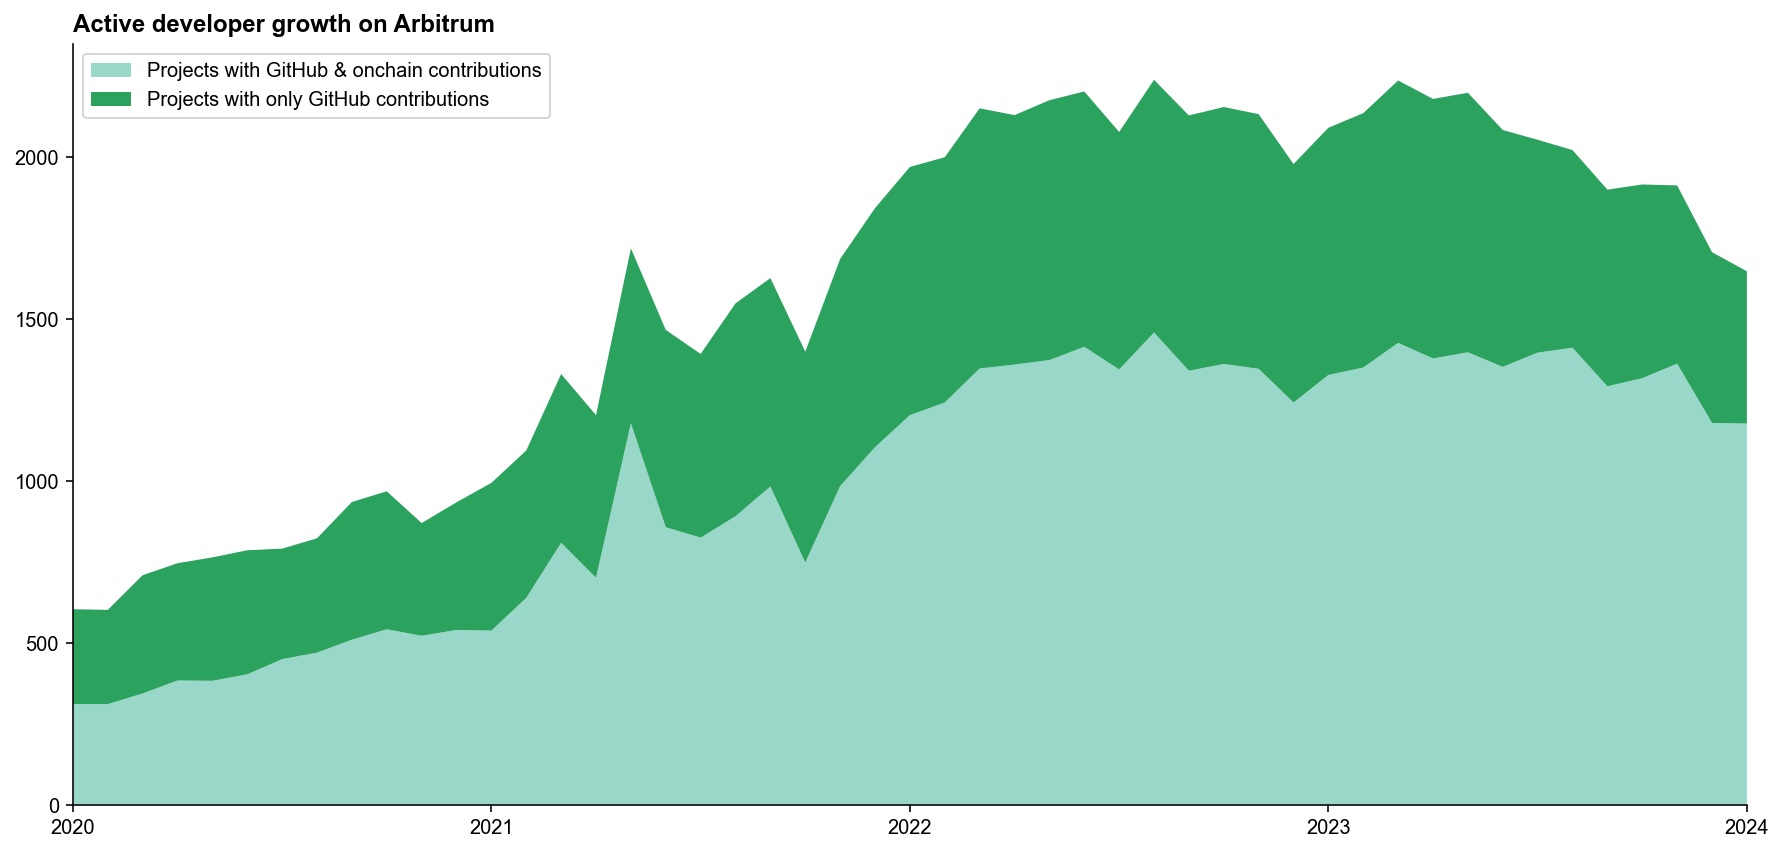

In [15]:
# visualize developer activity (all projects:contributor pairings) over time

fig, ax = plt.subplots(figsize=(15,7), facecolor='white', dpi=144)

months = df_devs['month'].nunique()
order = [ONCHAIN, OTHER]
pt = df_devs.pivot_table(
    index='month', 
    columns='collection', 
    values='developers', 
    #values='full_time_developer',     
    aggfunc='sum', 
    fill_value=0
)

ax.stackplot(pt.index, pt[order].T, labels=order, colors=[SEAFOAM, GREEN])

ax.set_xlim([0,months-1])
ax.set_xticks([x for x in range(0,months,12)])
xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
ax.set_xticklabels(xticklabels)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(loc='upper left')

ax.set_title('Active developer growth on Arbitrum', fontweight="bold", loc='left')

Text(0.0, 1.0, 'Active developer growth on Arbitrum (onchain projects only)')

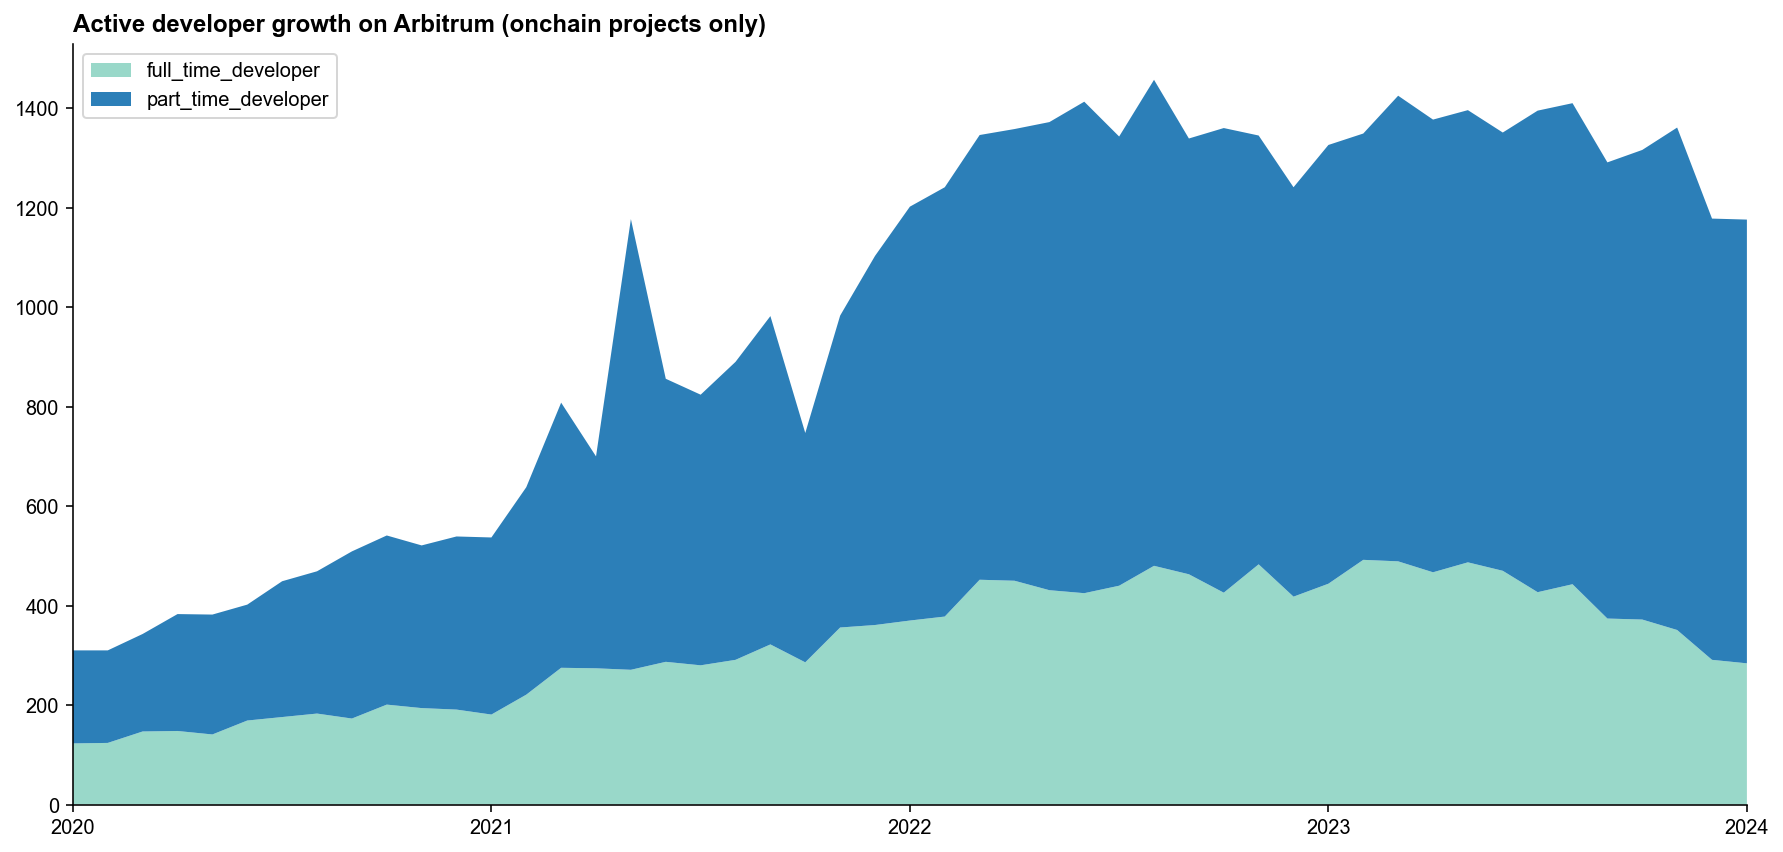

In [16]:
# visualize developer activity (all projects:contributor pairings) over time
fig, ax = plt.subplots(figsize=(15,7), facecolor='white', dpi=144)

months = df_devs['month'].nunique()
order = ['full_time_developer', 'part_time_developer']
gb = (
    df_devs[df_devs['collection']==ONCHAIN]
    .groupby('month')[order]
    .sum()
)
ax.stackplot(gb.index, gb.T, labels=order, colors=[SEAFOAM, TEAL])

ax.set_xlim([0,months-1])
ax.set_xticks([x for x in range(0,months,12)])
xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
ax.set_xticklabels(xticklabels)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(loc='upper left')

ax.set_title('Active developer growth on Arbitrum (onchain projects only)', fontweight="bold", loc='left')

Text(0.5, 0, '')

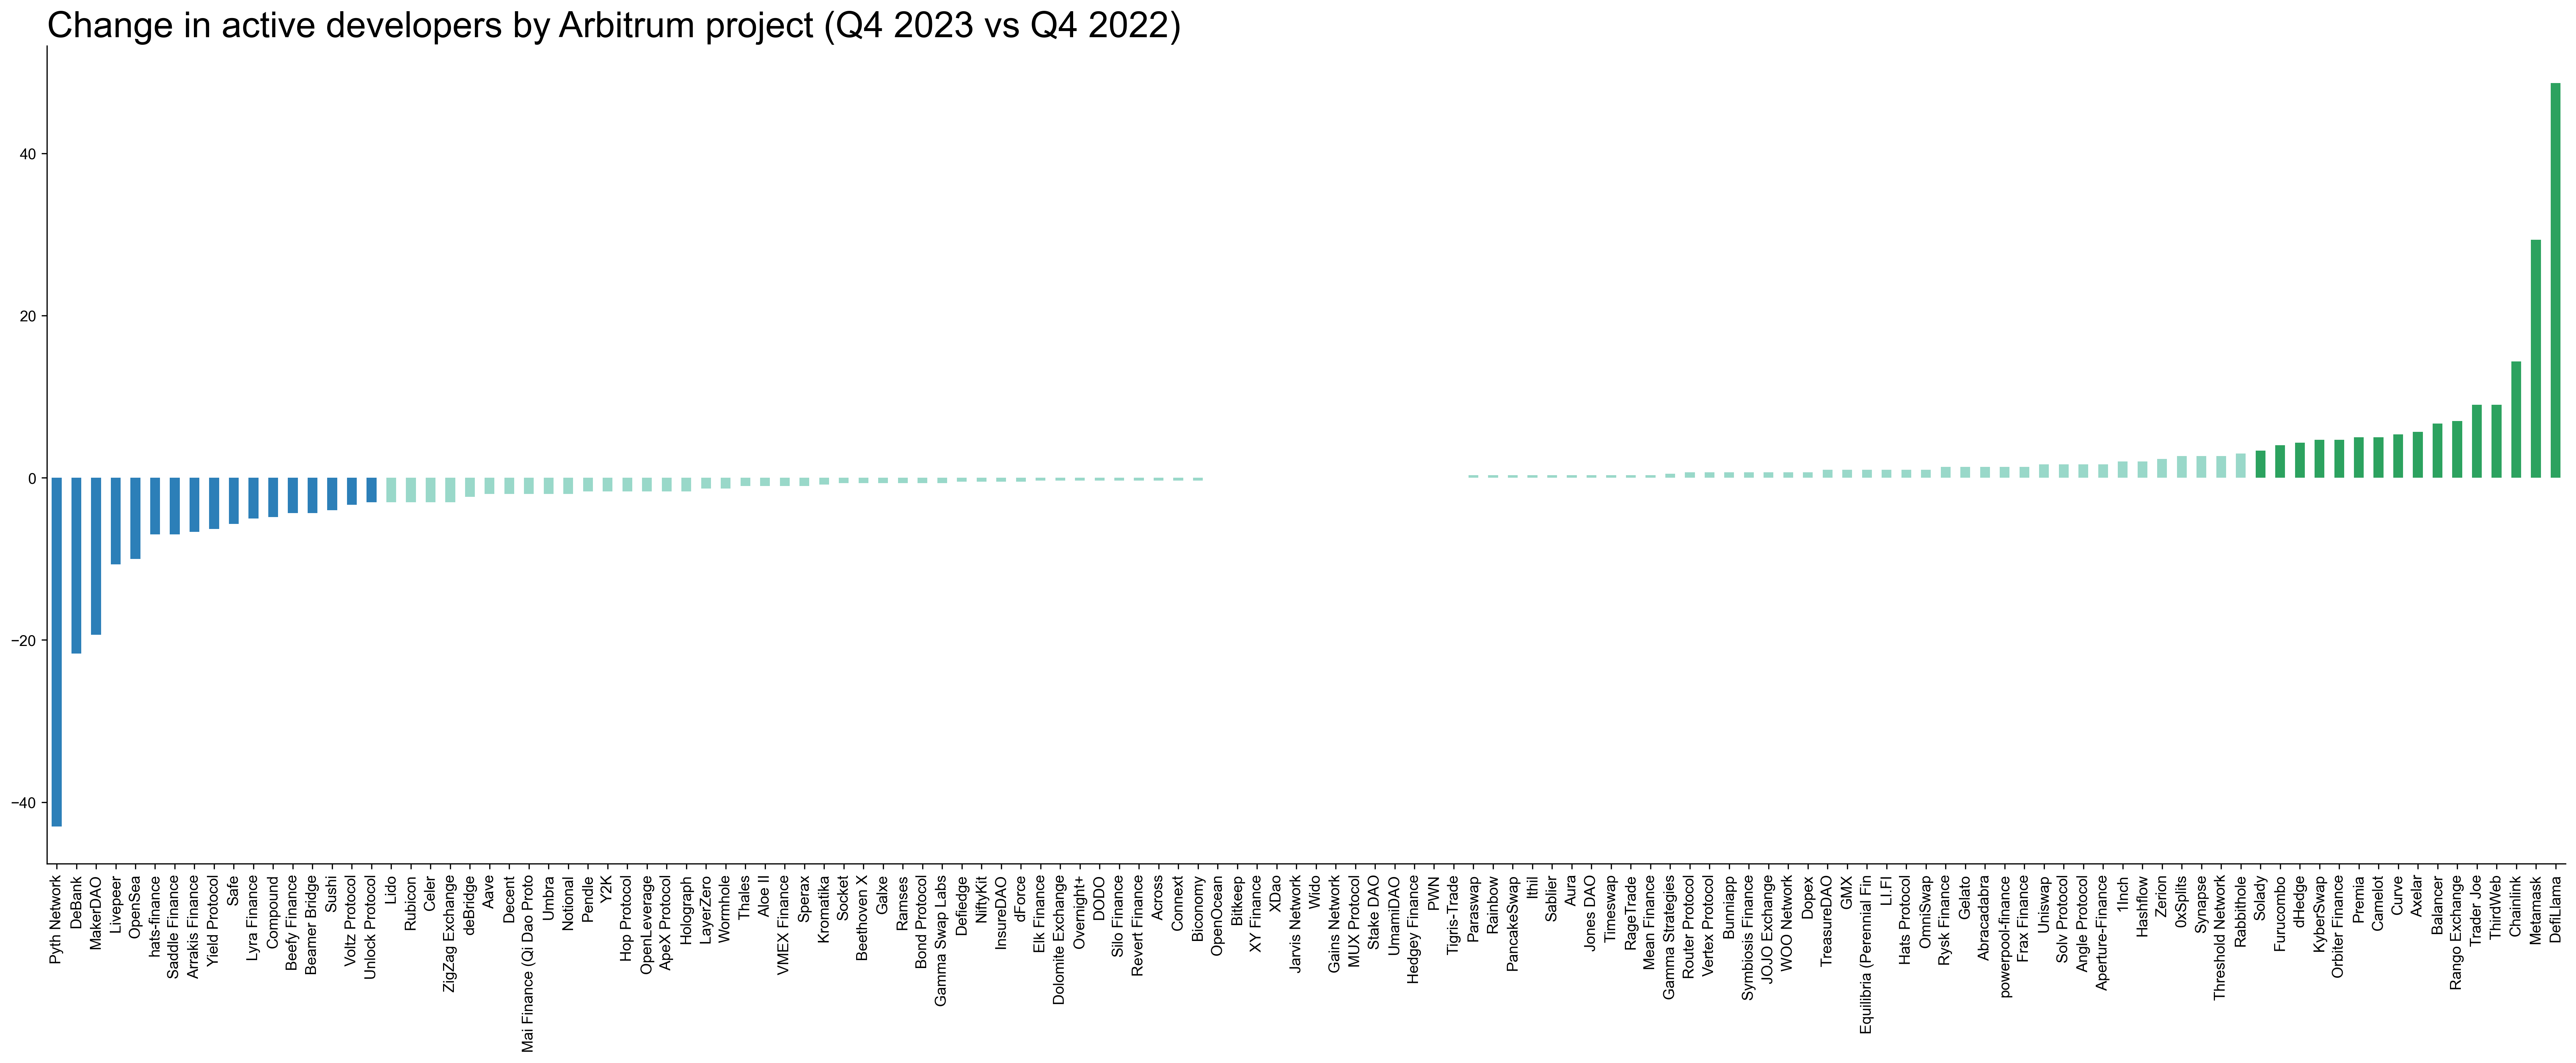

In [17]:
fig, ax = plt.subplots(figsize=(30,10), facecolor='white', dpi=300)

dff_devs = df_devs[df_devs['collection'] == ONCHAIN]

q4_2023 = dff_devs[dff_devs['month'].between('2023-10','2023-12')].groupby('project')['developers'].mean()
q4_2022 = dff_devs[dff_devs['month'].between('2022-10','2022-12')].groupby('project')['developers'].mean()
delta = (q4_2023 - q4_2022).dropna().sort_values()
delta_color = [{p<-3: TEAL, -3<=p<=3: SEAFOAM, p>3: GREEN}[True] for p in delta.values]
delta.plot(kind='bar', color=delta_color, ax=ax)

ax.set_title("Change in active developers by Arbitrum project (Q4 2023 vs Q4 2022)", loc='left', fontsize=24)
ax.set_xlabel("")

In [29]:
df_devs.groupby('month')['developers'].sum().tail(12)

month
2023-02    2134
2023-03    2235
2023-04    2178
2023-05    2197
2023-06    2082
2023-07    2052
2023-08    2020
2023-09    1898
2023-10    1914
2023-11    1911
2023-12    1705
2024-01    1646
Name: developers, dtype: int64

In [18]:
# make a heatmap
fig, ax = contribution_heatmap(
    df_devs[df_devs['project'].isin(delta.index)],
    index_col='project',
    column_col='month',
    value_col='full_time_developer',
    sort_label_method='mean',
    dpi=300,
    cmap='Blues',
    vmax=10,
    figsize=(15,40)
)

ax.set_title("Full-time developers by project in the Arbitrum ecosystem", fontweight="bold", loc='left', fontsize=24)

Text(0.0, 1.0, 'Full-time developers by project in the Arbitrum ecosystem')

Text(0.0, 1.0, 'Active developers among Arbitrum STIP projects')

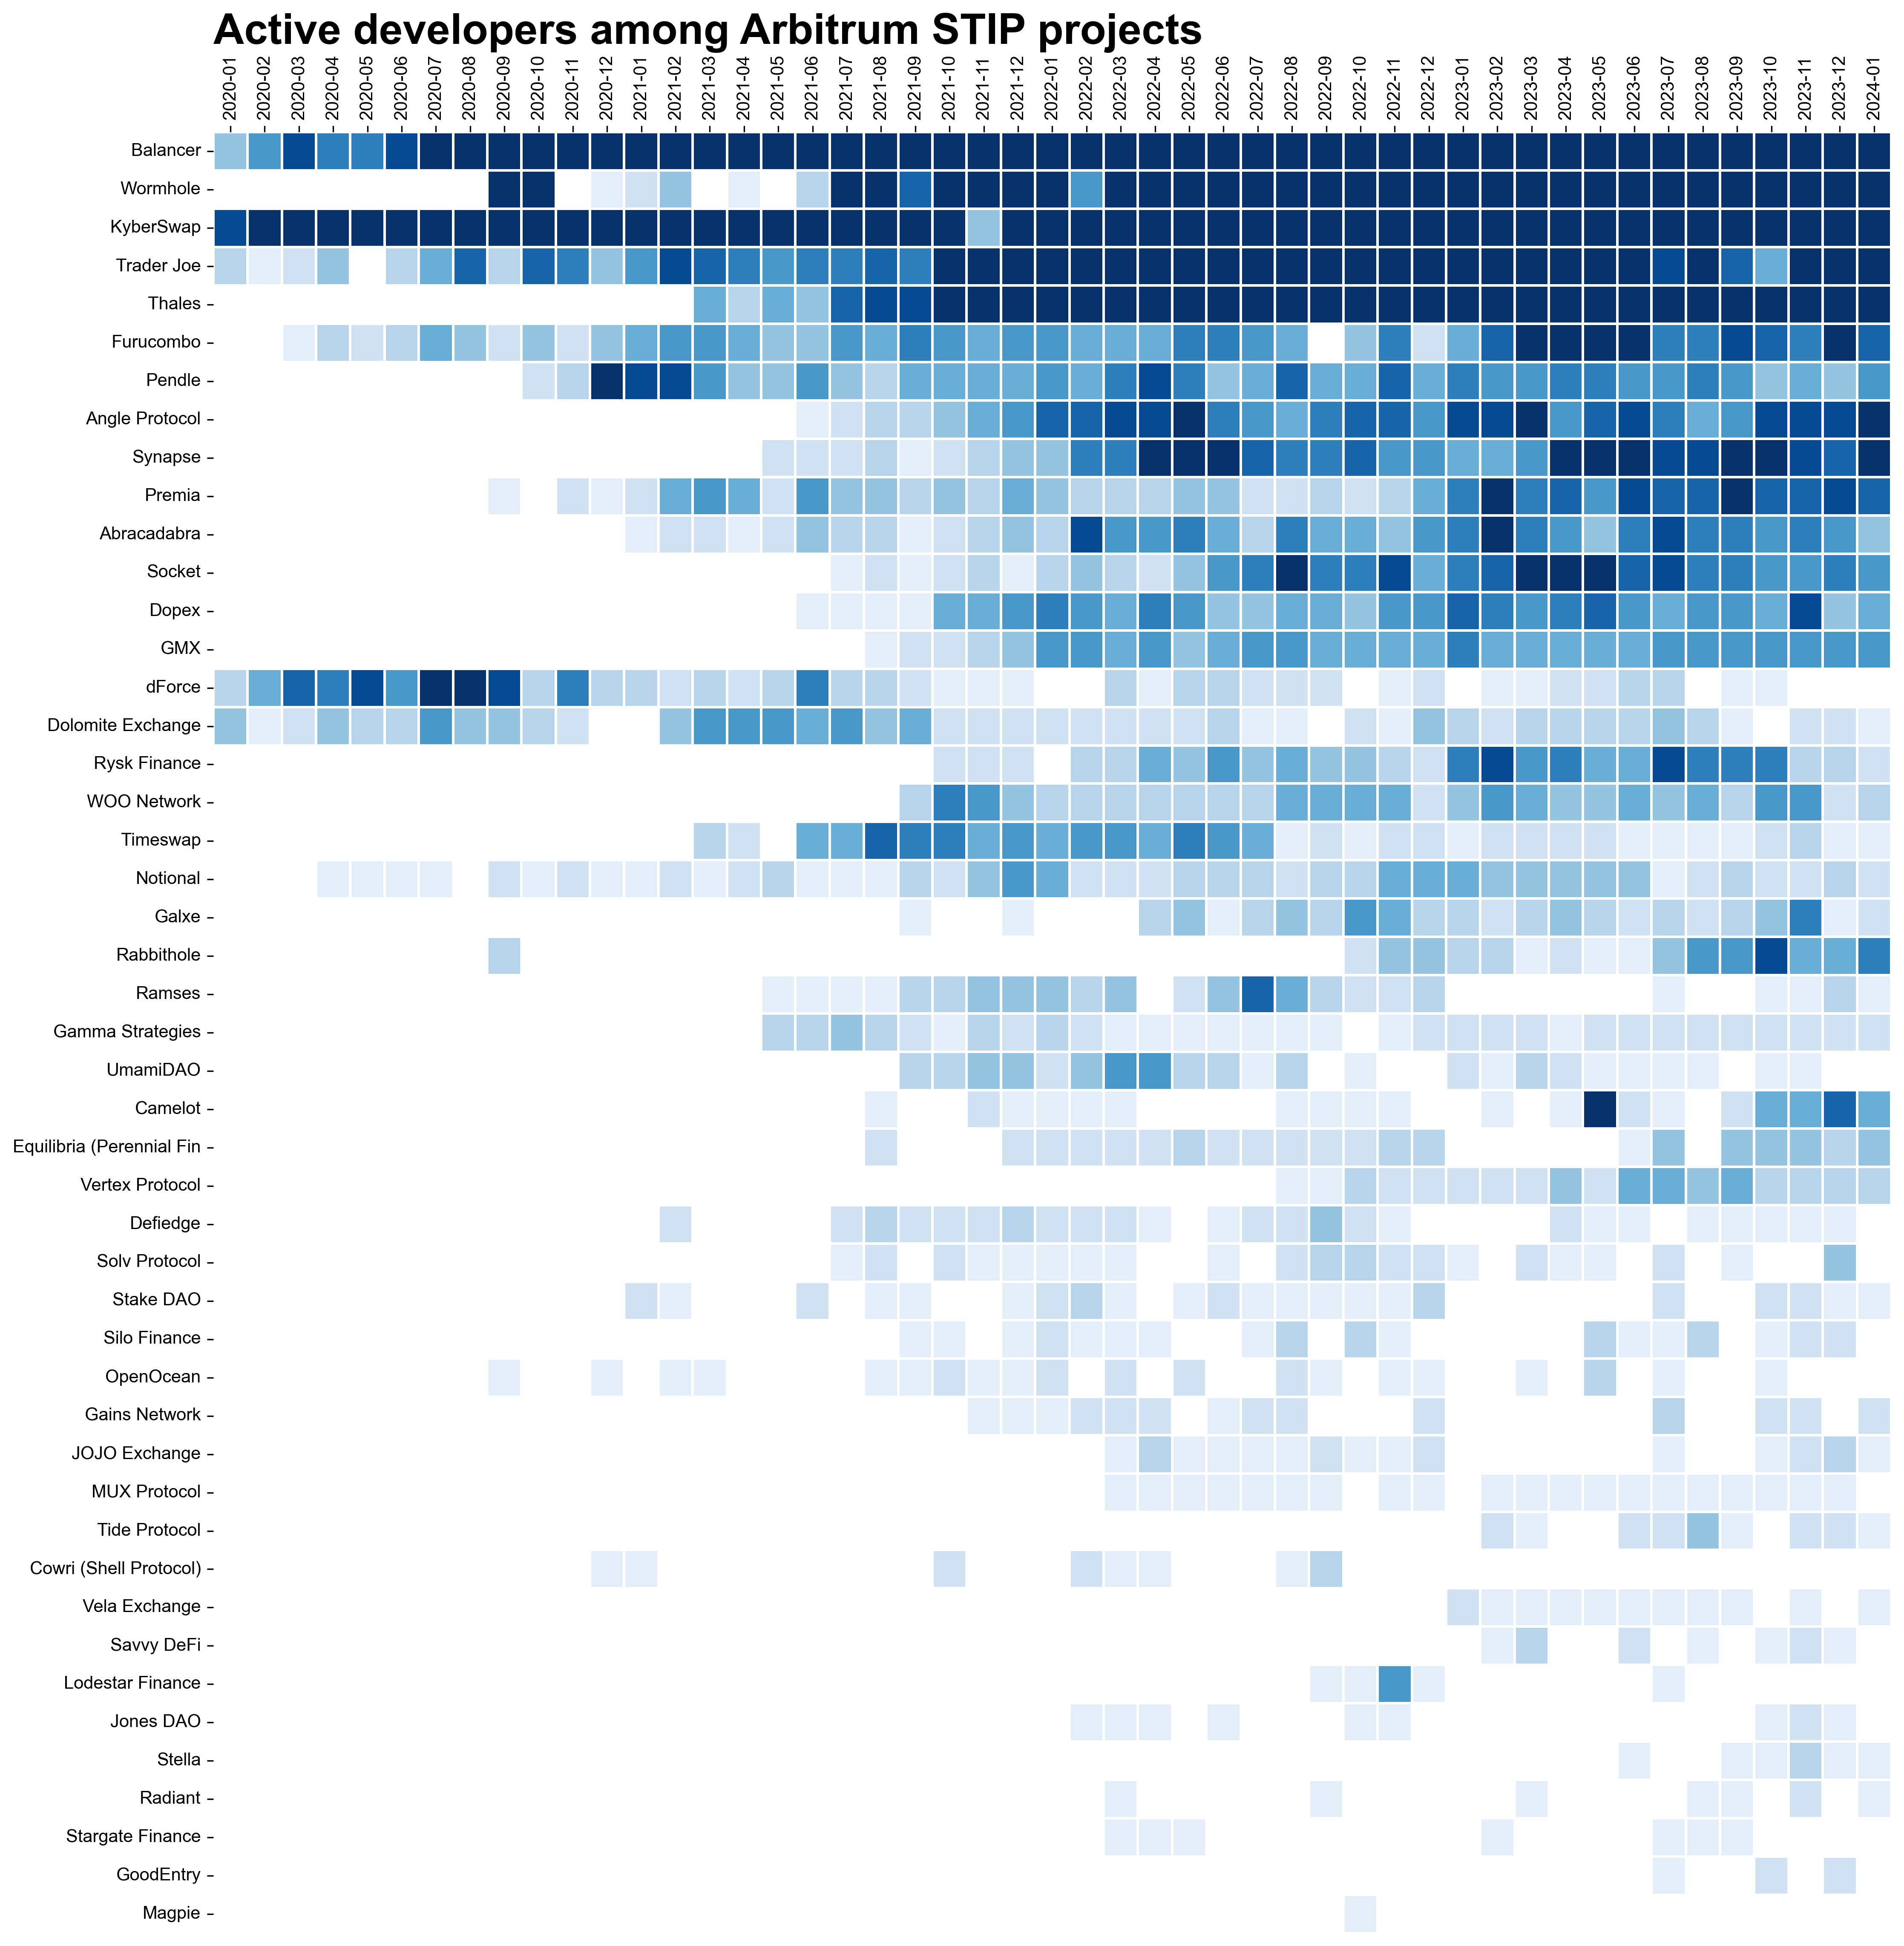

In [19]:
fig, ax = contribution_heatmap(
    df_devs[df_devs['slug'].isin(projects_to_collections['arb-stip-1'])],
    index_col='project',
    column_col='month',
    value_col='developers',
    sort_label_method='mean',
    dpi=300,
    cmap='Blues',
    vmax=10,
    figsize=(15,15)
)

ax.set_title("Active developers among Arbitrum STIP projects", fontweight="bold", loc='left', fontsize=24)